<a href="https://colab.research.google.com/github/tarmopungas/real-estate-price-prediction/blob/main/price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation
- Read in data
- Sorting rows
- Replace missing values

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

Mount Drive

In [ ]:
import collections
import glob
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Read data to dataframe


In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Content/kv-ads-2020-11-03T09-39-44_TARMO.jl') as f:
    df = pd.DataFrame([json.loads(l) for l in f.readlines()])

Imported data

In [ ]:
df.head(2)

,id,propertyType,transactionType,price,title,isPassive,category,description,extra,images,time_scraped,geo
0,3223307,COMMERCIAL,SALE,81900.0,"Müüa äripind, 450,7 m² - Metalli 10, Uhtna, Ra...",False,müüa äripind,"Laohoone UHTNAS\nKogupind 450,7 m², kinnistu, ...",{},[https://cache.kv.ee/iv2/obj/1_35_65197108.jpg...,2020-11-03T09:39:53,"{'lat': 59.3933179, 'lng': 26.5622543}"
1,2980510,APARTMENT,SALE,169600.0,"Müüa korter, 3 tuba - pargi 10-47, Karlova, Ta...",False,müüa korter,"Jagamine\nKorteriomand, kivimaja\nrõdu 40 m², ...","{'numRooms': 3, 'area': 64.0, 'yearConstructed...",[https://cache.kv.ee/iv2/obj/1_35_63309758.jpg...,2020-11-03T09:39:55,"{'lat': 58.3711681, 'lng': 26.7282354}"


In [ ]:
df.dtypes

id                   int64
propertyType        object
transactionType     object
price              float64
title               object
isPassive             bool
category            object
description         object
extra               object
images              object
time_scraped        object
geo                 object
dtype: object

Get all unique types of fields:


In [ ]:
print("Property types:")
print(pd.Series(df.propertyType).unique())

Property types:
['COMMERCIAL' 'APARTMENT' 'LAND' 'HOUSE_PART' 'HOUSE' 'GARAGE']


Dropping unnecessary columns; we only need apartment data

In [ ]:
df = df[df.isPassive == False]
df = df[df.propertyType == 'APARTMENT']
df = df[df.transactionType == 'RENTAL']
df.drop_duplicates(subset="id", keep='first', inplace=True)  # Remove rows with duplicate 'id' values
df = df.drop(columns=['images', 'isPassive', 'propertyType', 'transactionType', 'category', 'id', 'description'])

Extract data from 'extra' and insert it into new column


In [ ]:
df['numRooms'] = [i['numRooms'] for i in df['extra']]
df['area'] = [i['area'] for i in df['extra']]
df['yearConstructed'] = [i['yearConstructed'] for i in df['extra']]
df['state'] = [i['state'] for i in df['extra']]
df['energyClass'] = [d['energyClass'] for d in df['extra']]
df['floor'] = [float(str(i['floor']).strip(".")) if i['floor'] != None else None for i in df['extra']]

Extract address from 'title' and insert it into new column

In [ ]:
df['address'] = ["-".join(i.split("-")[1:]).strip(" ") for i in df['title']]
df = df.drop(columns=['extra', 'title'])

Extracting municipality and quarter (*linnaosa*) from address


In [ ]:
def hasNumbers(inputString):
  return any(char.isdigit() for char in inputString)

def uniqueLenghts(inputList):
  lengthsDict = {}
  for el in inputList:
    if len(el.split(", ")) not in lengthsDict:
      lengthsDict[len(el.split(", "))] = set()
      lengthsDict[len(el.split(", "))].add(el)

    else:
      lengthsDict[len(el.split(", "))].add(el)
  return lengthsDict

def findQuarterOfTallinn(inputString):
  alist = inputString.split(", ")
  for el in alist:
    if el.lower() in tallinna_linnaosad:
      return el
  return np.nan

# resDict = uniqueLenghts(df['address'])
tallinna_linnaosad = ['haabersti', 'põhja-tallinn', 'pirita', 'lasnamäe', 'kristiine', 'mustamäe', 'nõmme', 'kesklinn']

municipality = [(i.split(", ")[-2]).strip(" ") for i in df['address']]
df.insert(len(df.columns), 'municipality', municipality)

quarter = []
for i in df['address']:
  #if len(i.split(", ")) > 3 and (i.split(", ")[-2]).strip(" ") == 'Tallinn':
   # quarter.append(findQuarterOfTallinn(i))
  if len(i.split(", ")) > 3 and not hasNumbers(i.split(", ")[-3]):
    quarter.append((i.split(", ")[-3]).strip(" "))
  else:
    quarter.append(np.nan)

df.insert(len(df.columns), 'quarter', quarter)

In [ ]:
df.loc[(df['municipality']=="Tallinn") & (df['quarter'] == 'Kesklinn')].count

<bound method DataFrame.count of         price         time_scraped  ... municipality   quarter
20      900.0  2020-11-03T09:40:06  ...      Tallinn  Kesklinn
21      690.0  2020-11-03T09:40:07  ...      Tallinn  Kesklinn
23     1600.0  2020-11-03T09:40:08  ...      Tallinn  Kesklinn
43      320.0  2020-11-03T09:40:17  ...      Tallinn  Kesklinn
99      620.0  2020-11-03T09:41:03  ...      Tallinn  Kesklinn
...       ...                  ...  ...          ...       ...
23869   470.0  2020-11-03T15:30:04  ...      Tallinn  Kesklinn
23878   350.0  2020-11-03T15:30:11  ...      Tallinn  Kesklinn
23900   590.0  2020-11-03T15:30:26  ...      Tallinn  Kesklinn
23913   420.0  2020-11-03T15:30:36  ...      Tallinn  Kesklinn
23929   140.0  2020-11-03T15:30:46  ...      Tallinn  Kesklinn

[692 rows x 12 columns]>

Move 'geo' column to the very end


In [ ]:
geo = df.pop('geo')
df.insert(len(df.columns), 'geo', geo)

Replace missing values with NaN


In [ ]:
df = df.fillna(np.nan)
df['energyClass'] = df['energyClass'].replace('Puudub', np.nan)
df['energyClass'] = df['energyClass'].replace('-', np.nan)

Replace weird (erroneous) values by NaN / delete such rows

In [ ]:
df['yearConstructed'] = df['yearConstructed'].apply(lambda x: x if x >=1850 else np.nan)  # Year constructed > 1850
df['numRooms'] = df['numRooms'].apply(lambda x: x if x < 10 else np.nan)  # Number of rooms > 10
df = df.drop(df[df.price < 100].index)  # Price < 100
df = df.drop(df[df.area < 10].index)  # Area < 10
df = df.drop(df[df.area > 200].index)  # Area > 300

Remove timestamp from time_scraped (currently also dropping the column; if training on data scraped over a long time, should keep the column and one-hot encode it)

In [ ]:
df['time_scraped'] = df['time_scraped'].apply(lambda x: x.split('T')[0])
df = df.drop(columns=['time_scraped'])

#Geo clustering using OPTICS clustering
OPTICS works with geo-coordinates and it also deals with noise. Also it
has the ability to have clusters with varying densities.
min_samples=5, because it made decent amount of clusters(not too much and not too many) and also max_eps=0.1, to eliminate noise in clusters.
max_eps=01 is around 10km. One bad thing here is that in Estonia one
longitude is 111km and one latitude is ~57km, so longitude values have pretty much double the weight than latitude. Not sure if it's something worth taking into account or not.

In [ ]:
from sklearn.cluster import OPTICS
import matplotlib.gridspec as gridspec

In [ ]:
koordinaadid = np.array([[i['lng'], i['lat']] for i in df['geo']])
clust = OPTICS(min_samples=5, max_eps=0.1).fit(koordinaadid)
labels = clust.labels_[clust.ordering_]

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Insert clusters to dataframe

In [ ]:
df.insert(len(df.columns), 'cluster', labels)


Cluster plotting

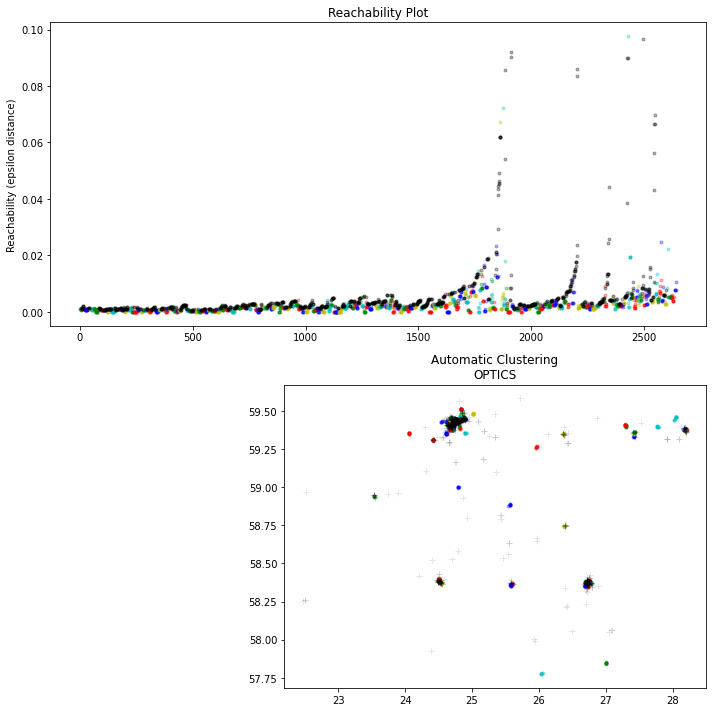

Total number of clusters: 203


In [ ]:
space = np.arange(len(koordinaadid))
reachability = clust.reachability_[clust.ordering_]
plt.figure(figsize=(10, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 1:])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for i in range(len(labels)):
    Xk = space[labels == i]
    Rk = reachability[labels == i]
    ax1.plot(Xk, Rk, colors[i % 5], alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for i in range(len(labels)):
    Xk = koordinaadid[clust.labels_ == i]
    ax2.plot(Xk[:, 0], Xk[:, 1], colors[i % 5], alpha=0.3)
ax2.plot(koordinaadid[clust.labels_ == -1, 0], koordinaadid[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

plt.tight_layout()
plt.show()
print("Total number of clusters:", (max(labels)+1))

Replace no cluster(-1) with NaN

In [ ]:
df['cluster'] = df['cluster'].replace(-1, np.nan)

# Visualisation and Tallinn data separation
 - plot all prices
 - plot coordinates on a map
 - GIS maps?

In [ ]:
import seaborn as sns

Histogram of prices

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f678a078f98>]],
      dtype=object)

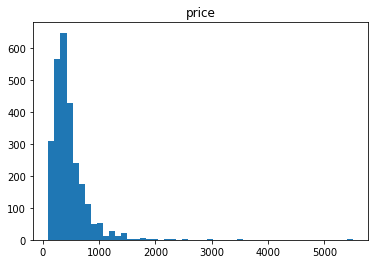

In [ ]:
df.hist(column='price', grid=False, bins=50)

Apartment price based on its condition

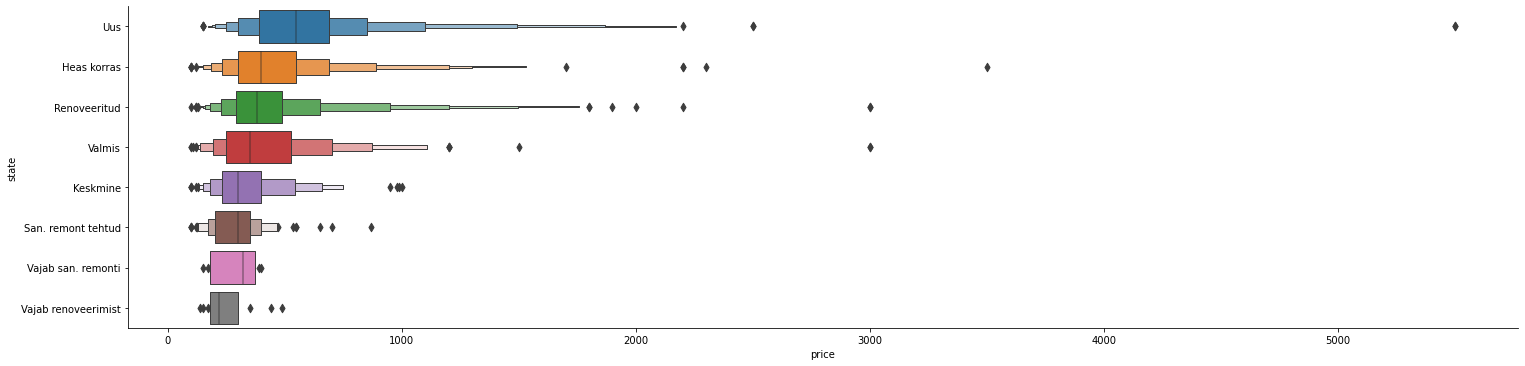

In [ ]:

ax = sns.catplot(y="state", x="price", data=df, kind="boxen", order=["Uus", "Heas korras", "Renoveeritud", "Valmis", "Keskmine", "San. remont tehtud", "Vajab san. remonti", "Vajab renoveerimist"])
ax.fig.set_size_inches(30, 5)

Geo coordinates plotted on a map (just for fun)
[Tutorial](https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db)

More blue means there are many properties in one coordinate

In [ ]:
df['latitude'] = [i['lat'] for i in df['geo']]
df['longitude'] = [i['lng'] for i in df['geo']]

In [ ]:
tallkesk = df.loc[(df['municipality']=="Tallinn") & (df['quarter']=="Kesklinn")]

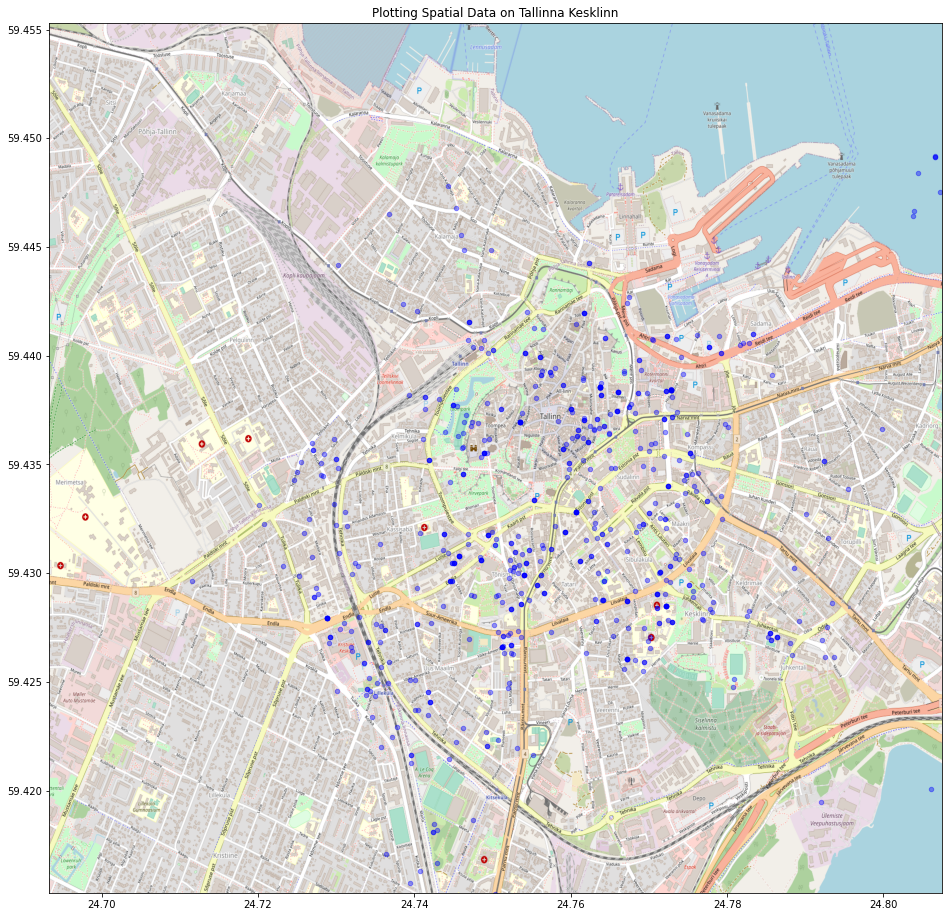

In [ ]:
import matplotlib.pyplot as plt

BBox = ((24.6933, 24.8075, 59.4153, 59.4553))

ruh_m = plt.imread('/content/drive/My Drive/Colab Notebooks/Content/map.png')

fig, ax = plt.subplots(figsize = (16,16))
ax.scatter(tallkesk.longitude, tallkesk.latitude, zorder=1,alpha=0.4, c='b', s=20)
ax.set_title('Plotting Spatial Data on Tallinna Kesklinn')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect='auto')

Make separate Tallinn dataframe to get a test model


In [ ]:
df.head(1)

,price,numRooms,area,yearConstructed,state,energyClass,floor,address,municipality,quarter,geo,cluster,latitude,longitude
20,900.0,3.0,72.0,2006.0,Heas korras,NaN,4.0,"Liivaoja tn 14, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.4404839691429, 'lng': 24.7817172232...",0.0,59.440484,24.781717


In [ ]:
import math

# Algorithm source: https://www.movable-type.co.uk/scripts/latlong.html
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d * 1000; # meters

In [ ]:
df_tln = df.copy()
df_tln = df_tln[df_tln.municipality == "Tallinn"]

kesklinn = [59.432601, 24.763224]
distances = []
for i in range(df_tln.shape[0]):
  dist = round(measure(df_tln.iloc[i][12], df_tln.iloc[i][13], kesklinn[0], kesklinn[1]))
  if dist > 15000:
    adres = df_tln.iloc[i, 7].split(",")[0]
    print(adres, df_tln.iloc[i][12], df_tln.iloc[i][13])
    adres_dict = {
        "Gonsiori 17": (59.434835, 24.765017),
        "Liikuri 16": (59.439472, 24.814190)
    }
    adres_d = adres_dict[adres]
    distances.append(round(measure(adres_d[0], adres_d[1], kesklinn[0], kesklinn[1])))
    continue
  distances.append(dist)


df_tln["distances"] = distances

df_tln_tarmo = df_tln.copy()

df_tln.head()

Gonsiori 17 58.37088 26.71483
Liikuri 16 59.3349122918542 25.2517184952759


,price,numRooms,area,yearConstructed,state,energyClass,floor,address,municipality,quarter,geo,cluster,latitude,longitude,distances
20,900.0,3.0,72.0,2006.0,Heas korras,NaN,4.0,"Liivaoja tn 14, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.4404839691429, 'lng': 24.7817172232...",0.0,59.440484,24.781717,1366
21,690.0,3.0,53.6,2016.0,Heas korras,B,2.0,"Mardi 6, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.4300083, 'lng': 24.7634477}",0.0,59.430008,24.763448,289
23,1600.0,2.0,63.5,2018.0,Uus,B,5.0,"Pirita Tee 20A, Pirita, Kesklinn, Tallinn, Har...",Tallinn,Kesklinn,"{'lat': 59.4464381, 'lng': 24.8037681}",0.0,59.446438,24.803768,2764
43,320.0,2.0,40.5,NaN,Uus,NaN,1.0,"Tobiase 2, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.43451, 'lng': 24.774737}",0.0,59.434510,24.774737,686
84,650.0,2.0,57.0,2008.0,Uus,NaN,2.0,"Räga 10, Haabersti, Tallinn, Harjumaa",Tallinn,Haabersti,"{'lat': 59.4268722, 'lng': 24.6274806}",0.0,59.426872,24.627481,7712


In [ ]:
#df_tln.iloc[1810,:]
print(df_tln.shape)

(1807, 15)


Make scatterplot in Tallinn for distance from city centre to price

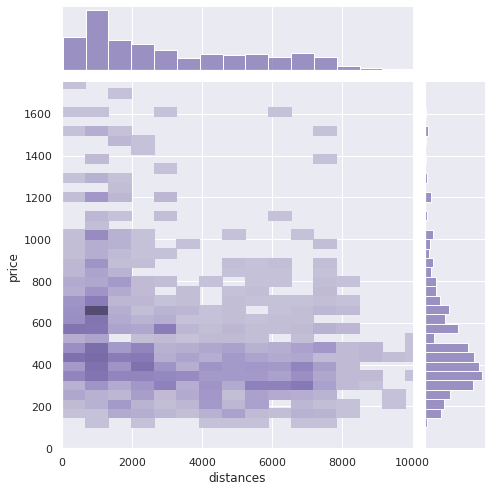

In [ ]:
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="distances", y="price", data=df_tln,
                  kind="hist",
                  xlim=(0, 10000), ylim=(0, 1750),
                  color="m", height=7)

Histoplot with categories

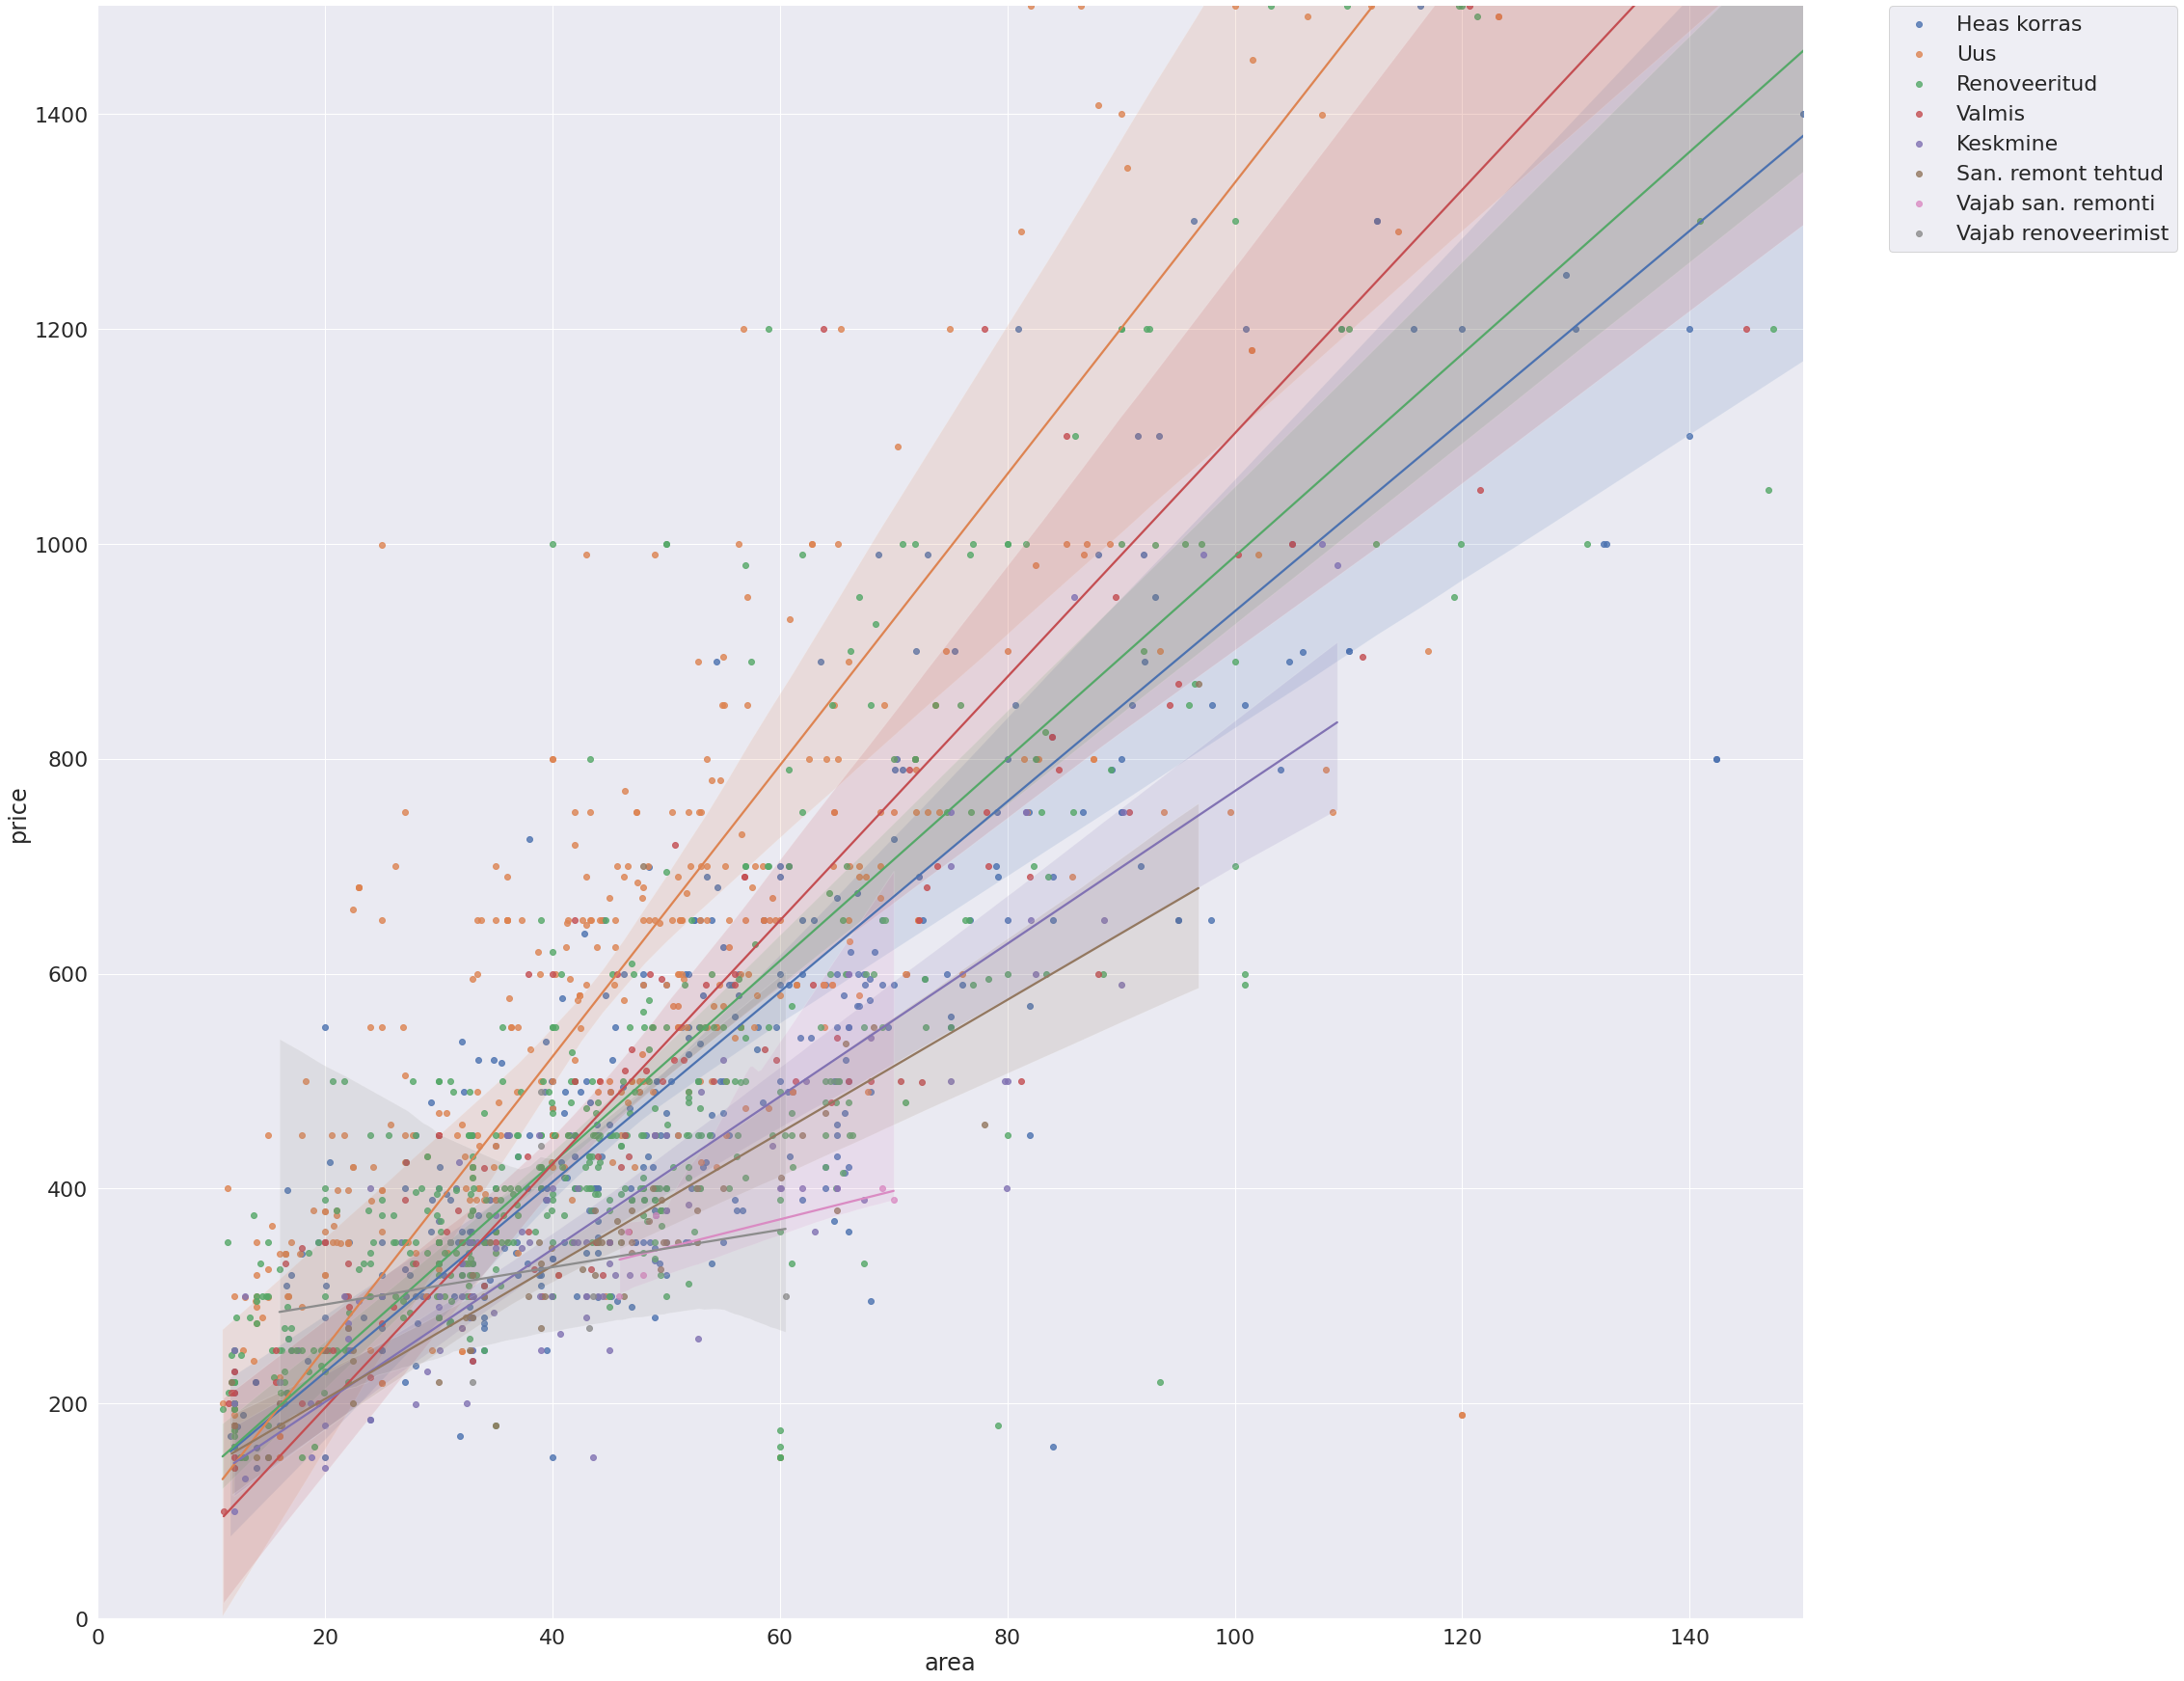

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
l = sns.lmplot(x="area", y="price", hue="state", data=df_tln, legend = False)
l.fig.set_size_inches(40, 30)  
l.set(ylim=(0, 1500))
l.ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
l.set(xlim=(0, 150))



Drop obsolete location columns

In [ ]:
df_tln = df_tln.drop(columns=['address', 'geo', 'latitude', 'longitude'])

# Preparing data for training: dummy values and splitting

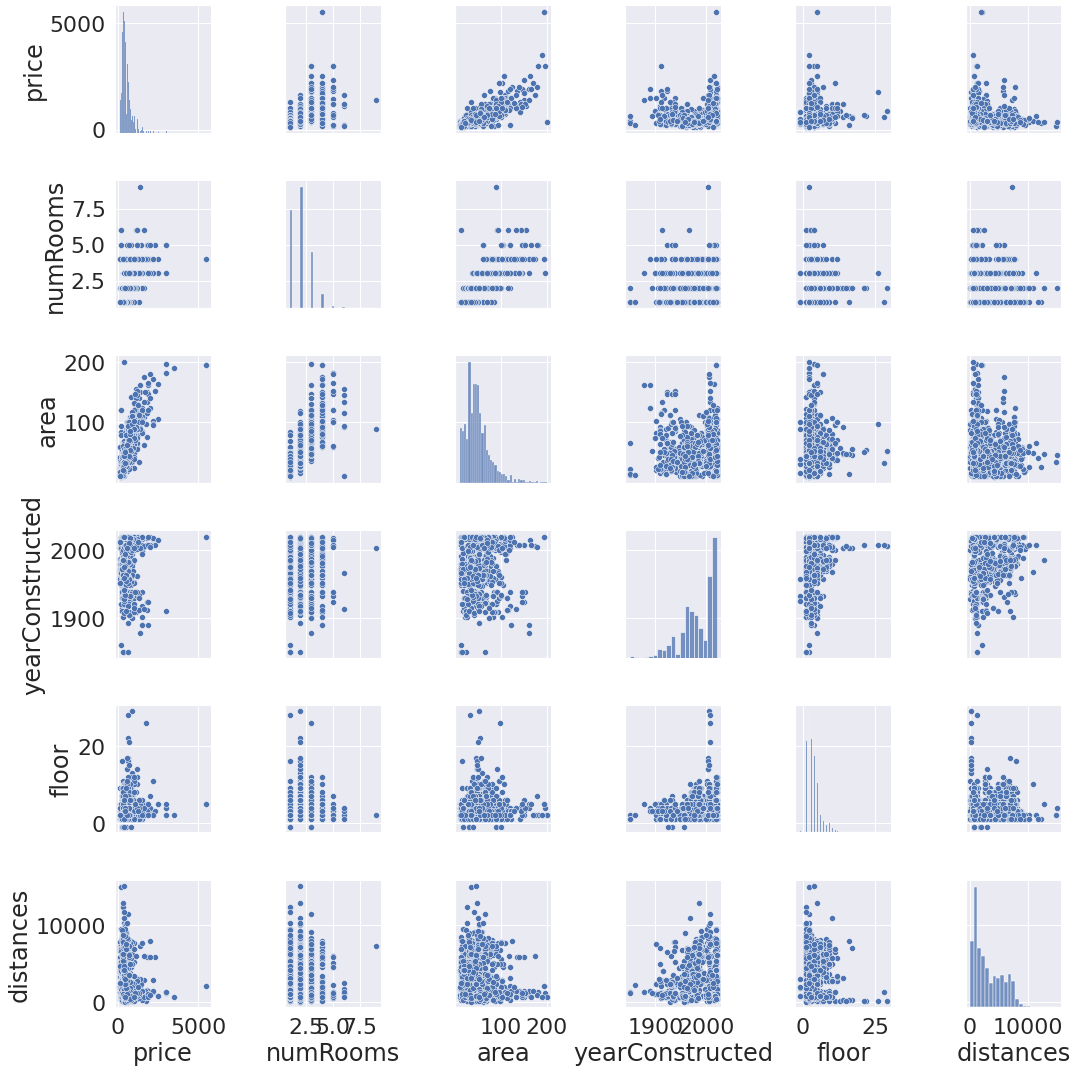

In [ ]:
%matplotlib inline
# Calculate and show pairplot
sns.pairplot(df_tln.drop(columns=['cluster']), height=2.5)
plt.tight_layout()

In [ ]:
df_tln.head()

,price,numRooms,area,yearConstructed,state,energyClass,floor,municipality,quarter,cluster,distances
20,900.0,3.0,72.0,2006.0,Heas korras,NaN,4.0,Tallinn,Kesklinn,0.0,1366
21,690.0,3.0,53.6,2016.0,Heas korras,B,2.0,Tallinn,Kesklinn,0.0,289
23,1600.0,2.0,63.5,2018.0,Uus,B,5.0,Tallinn,Kesklinn,0.0,2764
43,320.0,2.0,40.5,NaN,Uus,NaN,1.0,Tallinn,Kesklinn,0.0,686
84,650.0,2.0,57.0,2008.0,Uus,NaN,2.0,Tallinn,Haabersti,0.0,7712


First model will be done with property values from Tallinn as it has the most listings.
First let's get the dummy values:

In [ ]:
df_tln_d = pd.get_dummies(df_tln, columns = ["energyClass","state", "quarter", "municipality", "cluster"], dummy_na=True)
df_tln_d.head()

,price,numRooms,area,yearConstructed,floor,distances,energyClass_A,energyClass_B,energyClass_C,energyClass_D,energyClass_E,energyClass_F,energyClass_G,energyClass_nan,state_Heas korras,state_Keskmine,state_Renoveeritud,state_San. remont tehtud,state_Uus,state_Vajab renoveerimist,state_Vajab san. remonti,state_Valmis,state_nan,quarter_Haabersti,quarter_Kadriorg,quarter_Kesklinn,quarter_Kristiine,quarter_Lasnamäe,quarter_Mustamäe,quarter_Nõmme,quarter_Pirita,quarter_Põhja-Tallinn,quarter_Vanalinn,quarter_nan,municipality_Tallinn,municipality_nan,cluster_0.0,cluster_1.0,cluster_2.0,cluster_3.0,...,cluster_164.0,cluster_165.0,cluster_166.0,cluster_167.0,cluster_168.0,cluster_169.0,cluster_170.0,cluster_171.0,cluster_172.0,cluster_173.0,cluster_174.0,cluster_175.0,cluster_176.0,cluster_177.0,cluster_178.0,cluster_179.0,cluster_180.0,cluster_181.0,cluster_182.0,cluster_183.0,cluster_184.0,cluster_185.0,cluster_186.0,cluster_187.0,cluster_188.0,cluster_189.0,cluster_190.0,cluster_191.0,cluster_192.0,cluster_193.0,cluster_194.0,cluster_195.0,cluster_196.0,cluster_197.0,cluster_198.0,cluster_199.0,cluster_200.0,cluster_201.0,cluster_202.0,cluster_nan
20,900.0,3.0,72.0,2006.0,4.0,1366,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,690.0,3.0,53.6,2016.0,2.0,289,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,1600.0,2.0,63.5,2018.0,5.0,2764,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43,320.0,2.0,40.5,NaN,1.0,686,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
84,650.0,2.0,57.0,2008.0,2.0,7712,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's deal with nan values. We'll use so called MICE imputation. In sklearn it has the equilent of sklearn.impute.IterativeImputer. This method is good because it predicts the nan value from the data it has in it's row already. I use all the default values. Could be made faster if used some custom attributes(skip_complete etc). Probably will lose a bit in accuracy then

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer()
imp.fit(df_tln_d)
imputed_df_tln_d = pd.DataFrame(data=imp.transform(df_tln_d), 
                             columns=list(df_tln_d),
                             dtype='float')
imputed_df_tln_d.head()

,price,numRooms,area,yearConstructed,floor,distances,energyClass_A,energyClass_B,energyClass_C,energyClass_D,energyClass_E,energyClass_F,energyClass_G,energyClass_nan,state_Heas korras,state_Keskmine,state_Renoveeritud,state_San. remont tehtud,state_Uus,state_Vajab renoveerimist,state_Vajab san. remonti,state_Valmis,state_nan,quarter_Haabersti,quarter_Kadriorg,quarter_Kesklinn,quarter_Kristiine,quarter_Lasnamäe,quarter_Mustamäe,quarter_Nõmme,quarter_Pirita,quarter_Põhja-Tallinn,quarter_Vanalinn,quarter_nan,municipality_Tallinn,municipality_nan,cluster_0.0,cluster_1.0,cluster_2.0,cluster_3.0,...,cluster_164.0,cluster_165.0,cluster_166.0,cluster_167.0,cluster_168.0,cluster_169.0,cluster_170.0,cluster_171.0,cluster_172.0,cluster_173.0,cluster_174.0,cluster_175.0,cluster_176.0,cluster_177.0,cluster_178.0,cluster_179.0,cluster_180.0,cluster_181.0,cluster_182.0,cluster_183.0,cluster_184.0,cluster_185.0,cluster_186.0,cluster_187.0,cluster_188.0,cluster_189.0,cluster_190.0,cluster_191.0,cluster_192.0,cluster_193.0,cluster_194.0,cluster_195.0,cluster_196.0,cluster_197.0,cluster_198.0,cluster_199.0,cluster_200.0,cluster_201.0,cluster_202.0,cluster_nan
0,900.0,3.0,72.0,2006.000000,4.0,1366.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,690.0,3.0,53.6,2016.000000,2.0,289.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1600.0,2.0,63.5,2018.000000,5.0,2764.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,320.0,2.0,40.5,1993.228822,1.0,686.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,650.0,2.0,57.0,2008.000000,2.0,7712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now lets split the data into training, validation and testing.

In [ ]:
from sklearn.model_selection import train_test_split
target_values = imputed_df_tln_d["price"]
features = imputed_df_tln_d.drop("price", axis = 1)

# Splitting data: 80% training, 10% testing, 10% validation

X_train, X_test, y_train, y_test = train_test_split(features, target_values, train_size= 0.8, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)


# Training the first two models: Ridge Regression and Lasso

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
df_tln_tarmo.head()

,price,numRooms,area,yearConstructed,state,energyClass,floor,address,municipality,quarter,geo,cluster,latitude,longitude,distances
20,900.0,3.0,72.0,2006.0,Heas korras,NaN,4.0,"Liivaoja tn 14, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.4404839691429, 'lng': 24.7817172232...",0.0,59.440484,24.781717,1366
21,690.0,3.0,53.6,2016.0,Heas korras,B,2.0,"Mardi 6, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.4300083, 'lng': 24.7634477}",0.0,59.430008,24.763448,289
23,1600.0,2.0,63.5,2018.0,Uus,B,5.0,"Pirita Tee 20A, Pirita, Kesklinn, Tallinn, Har...",Tallinn,Kesklinn,"{'lat': 59.4464381, 'lng': 24.8037681}",0.0,59.446438,24.803768,2764
43,320.0,2.0,40.5,NaN,Uus,NaN,1.0,"Tobiase 2, Kesklinn, Tallinn, Harjumaa",Tallinn,Kesklinn,"{'lat': 59.43451, 'lng': 24.774737}",0.0,59.434510,24.774737,686
84,650.0,2.0,57.0,2008.0,Uus,NaN,2.0,"Räga 10, Haabersti, Tallinn, Harjumaa",Tallinn,Haabersti,"{'lat': 59.4268722, 'lng': 24.6274806}",0.0,59.426872,24.627481,7712


In [ ]:
df_tln_re = df_tln_tarmo.drop(columns=["latitude", "longitude", "geo", "address", "quarter", "municipality"]) # Try dropping quarter, municipality and cluster (maybe the result is better)

In [ ]:
df_tln

,price,numRooms,area,yearConstructed,state,energyClass,floor,municipality,quarter,cluster,distances
20,900.0,3.0,72.0,2006.0,Heas korras,NaN,4.0,Tallinn,Kesklinn,0.0,1366
21,690.0,3.0,53.6,2016.0,Heas korras,B,2.0,Tallinn,Kesklinn,0.0,289
23,1600.0,2.0,63.5,2018.0,Uus,B,5.0,Tallinn,Kesklinn,0.0,2764
43,320.0,2.0,40.5,NaN,Uus,NaN,1.0,Tallinn,Kesklinn,0.0,686
84,650.0,2.0,57.0,2008.0,Uus,NaN,2.0,Tallinn,Haabersti,0.0,7712
...,...,...,...,...,...,...,...,...,...,...,...
23878,350.0,2.0,45.0,1959.0,NaN,F,1.0,Tallinn,Kesklinn,NaN,704
23879,700.0,3.0,70.3,2011.0,NaN,C,2.0,Tallinn,Põhja-Tallinn,NaN,3515
23900,590.0,2.0,62.9,2003.0,Valmis,NaN,2.0,Tallinn,Kesklinn,NaN,971
23913,420.0,2.0,51.5,NaN,NaN,D,3.0,Tallinn,Kesklinn,NaN,561


In [ ]:
df_tln_re = pd.get_dummies(df_tln_re, columns = ["energyClass","state"], dummy_na=True)

In [ ]:
imp = IterativeImputer()
imp.fit(df_tln_re)
imputed_df_tln_re = pd.DataFrame(data=imp.transform(df_tln_re), 
                             columns=list(df_tln_re),
                             dtype='float')

In [ ]:
target_values = imputed_df_tln_re["price"]
features = imputed_df_tln_re.drop("price", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(features, target_values, train_size= 0.8, random_state=1)

In [ ]:
def get_best_alpha(model,X,y,alphas):
    kf = KFold(n_splits=3, shuffle=False)
    results = []
    for alpha in alphas:
        model.set_params(alpha=alpha)
        for train_indexes, test_indexes in kf.split(X):
            X_test, X_val = X.values[train_indexes], X.values[test_indexes]
            y_test, y_val = y.values[train_indexes], y.values[test_indexes]

            model.fit(X_test, y_test)
            mse = mean_squared_error(y_val,model.predict(X_val))
            results.append((alpha, mse))
   

    best_alpha, mse = sorted(results, key=lambda x: x[1])[0]
    return best_alpha, mse

def error_margin(y_target, y_pred):
  return abs(y_target - y_pred) / y_target

def MSE(y_target, y_pred):
    return (y_target-y_pred)**2

def test_model(y_test, y_pred):
  mse = []
  error = []

  for pair in zip(y_test, y_pred):  
      mse.append(MSE(pair[0], pair[1]))
      error.append(error_margin(pair[0], pair[1]))

  print(str(round(1/len(error)*sum(error)*100,2)) + "% – average error percentage")

def testForest(y_test, y_pred):
  error = []

  for pair in zip(y_test, y_pred):  
      error.append(error_margin(pair[0], pair[1]))

  return round(1/len(error)*sum(error)*100,2)


Cross-validation on training dataset to find better regularization parameter alpha for Ridge and Lasso regression models.

In [ ]:
ridge_alphas = np.linspace(0.1, 10, 100)
lasso_alphas = np.linspace(0.001, 5, 100)

ridge_best_alpha = get_best_alpha(Ridge(), X_train, y_train, ridge_alphas)
lasso_best_alpha = get_best_alpha(Lasso(), X_train, y_train, lasso_alphas)
print("Ridge best alpha %.4f - Avg MSE %.4f " % ridge_best_alpha)
print("Lasso best alpha %.4f - Avg MSE %.4f " % lasso_best_alpha)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1974502.7355978005, tolerance: 14153.469633852545
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1549133.8461848386, tolerance: 10907.16409989616
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871825.764485173, tolerance: 10919.414286721993
  positive)


Ridge best alpha 10.0000 - Avg MSE 27118.5944 
Lasso best alpha 3.5861 - Avg MSE 26803.6284 


Training and fitting the models with calculated best alpha

In [ ]:
ridge = Ridge(alpha=ridge_best_alpha[0]).fit(X_train, y_train)
lasso = Lasso(alpha=lasso_best_alpha[0]).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

Calculating average error percentage and mean standard error

In [ ]:
test_model(y_test, y_pred_ridge)
test_model(y_test, y_pred_lasso)

24.6% – average error percentage
24.22% – average error percentage


# Training many more regressive models

[Source](https://yalantis.com/blog/predictive-algorithm-for-house-price/)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


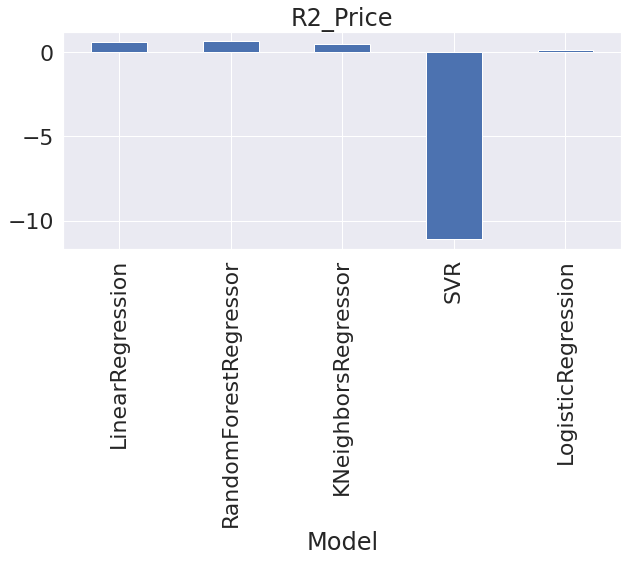

In [ ]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
 
Xtrn, Xtest, Ytrn, Ytest = train_test_split(imputed_df_tln_d.drop("price", axis = 1), imputed_df_tln_d[['price']], test_size=0.2)

models = [LinearRegression(),
          RandomForestRegressor(n_estimators=100, max_features='sqrt'),
          KNeighborsRegressor(n_neighbors=6),
          SVR(kernel='linear', max_iter=10000),
          LogisticRegression()
          ]

TestModels = pd.DataFrame()
tmp = {}

for model in models:
    # get model name
    m = str(model)
    tmp['Model'] = m[:m.index('(')]
    # fit model on training dataset
    model.fit(Xtrn, Ytrn['price'])
    # predict prices for test dataset and calculate r^2
    tmp['R2_Price'] = r2_score(Ytest['price'], model.predict(Xtest))
    # write obtained data
    TestModels = TestModels.append([tmp])

TestModels.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(10, 4))
TestModels.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_features='sqrt').fit(X_train, y_train).predict(X_test)
test_model(y_test, rf)

17.36% – average error percentage


Trying to improve RandomForestRegressor by hyperparameter tuning



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target_values, train_size= 0.8, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

from random import randint, uniform
from sklearn.metrics import accuracy_score
results_df = pd.DataFrame(columns=['model', 'accuracy'])

for i in range(1000):
    rf = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf = randint(1, 10), max_depth = randint(3, 70), min_samples_split = randint(2,10), min_weight_fraction_leaf = uniform(0.0, 0.3), max_features = ["auto", "sqrt", "log2"][randint(0, 2)])
    rf.fit(X_train, y_train)
    acc = 100 - testForest(y_val, rf.predict(X_val))
    results_df = results_df.append({'model': rf, 'accuracy': acc}, ignore_index=True)
    
results_df = results_df.sort_values('accuracy', ascending = False)
pd.set_option('display.max_colwidth', None)

In [ ]:
print(results_df['accuracy'].head(1))

543    81.96
Name: accuracy, dtype: float64


# Prediction using DNN - deep neural network
## Accuracy: 23-25%

Now we'll try neural network approach with Tensorflow keras Sequential. We will again focus only on Tallinn's properties.

In [ ]:
import keras

First we replace String values with a representive number.
We will drop "municipality" and "quarter", as they dont contribute to the price as much as the distance.
After some testing the model's accuracy would still be the same even if we would drop also "floor", "cluster", and "yearConstructed". They seem inconsequential as older building might be neatly restores

In [ ]:
df_tln_dnn = df_tln.drop(columns=["municipality", "quarter", "cluster", "yearConstructed", "floor"])
df_tln_dnn = df_tln_dnn.fillna(0)
df_tln_dnn['energyClass'].value_counts()
mapping = {'A': 7, 'B': 6, 'C': 5,'D': 4, 'E': 3, 'F': 2, 'G': 1}
mapping_state = {"Uus": 8, "Heas korras": 7, "Renoveeritud": 6, "Valmis": 5, "Keskmine": 4, "San. remont tehtud": 3, "Vajab renoveerimist": 2, "Vajab san. remonti": 1}
df_tln_dnn = df_tln_dnn.applymap(lambda s: mapping.get(s) if s in mapping else s)
df_tln_dnn = df_tln_dnn.applymap(lambda s: mapping_state.get(s) if s in mapping_state else s)

**Split the data into Test, train and validation sets**
80% training, 10% testing, 10% validation

In [ ]:
df_tln_features = df_tln_dnn.drop(columns=["price"], axis = 1)
df_tln_target = df_tln_dnn["price"]
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(df_tln_features, df_tln_target, train_size= 0.8, random_state=1)

Now we get to the juicy part where we create our hidden layers for the network.
As the MSE is approximatly the same with 5 features as it is with 8, we'll use less for computational efficiency. 

If we would have less fields missing we would need the most features that correlate with price. In our case it's complicated.

Smart stuff: Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments and according to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

In [ ]:
from keras.layers import Dense, Dropout

Our layers will be the size of
**5 -> 8 -> 4 -> 1**
There is no secret formula to choosing layers other than testing and guessing.

In [ ]:
model = keras.Sequential()
model.add(Dense(5, activation='relu', input_shape=(5, )))
model.add(Dropout(0.1))

model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 119
Trainable params: 119
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-8 less"
        min_delta=1e-8,
        # "no longer improving" being further defined as "for at least 6 epochs"
        patience=6,
        verbose=1
    )
]

model.fit(X_train_d, y_train_d, epochs=100, validation_split=0.2, callbacks=callbacks)

y_pred_d = model.predict(X_test_d)
y_pred_d = y_pred_d.reshape(1, len(y_pred_d))

test_model(y_test_d, y_pred_d[0])

Epoch 1/100
37/37 [==============================] - 0s 5ms/step - loss: 397558.5312 - val_loss: 424266.3125
Epoch 2/100
37/37 [==============================] - 0s 1ms/step - loss: 381703.2188 - val_loss: 322014.6562
Epoch 3/100
37/37 [==============================] - 0s 1ms/step - loss: 276642.7500 - val_loss: 296744.8438
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 266547.2812 - val_loss: 296196.4062
Epoch 5/100
37/37 [==============================] - 0s 1ms/step - loss: 266543.2812 - val_loss: 295488.6250
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 266405.3438 - val_loss: 294932.3438
Epoch 7/100
37/37 [==============================] - 0s 1ms/step - loss: 263942.8438 - val_loss: 294248.1875
Epoch 8/100
37/37 [==============================] - 0s 1ms/step - loss: 265204.7812 - val_loss: 293694.0625
Epoch 9/100
37/37 [==============================] - 0s 1ms/step - loss: 264470.5938 - val_loss: 293028.2812
Epoch 10/100
37/37 